# Improving Starbucks Offer Targeting with Redemption Prediction

## 01. Data Preprocessing

This is the first notebook out of 3 which details the steps taken to clean data, engineer new features and visualize preliminary relationships between variables.

<b> Content </b>

- [1. Data Cleaning](#section1)
    - [1.1 Portfolio Dataset](#section1.1)
    - [1.2 Profile Dataset](#section1.2)
    - [1.3 Transcript Dataset](#section1.3)
    
- [2. Create Combined DataFrame for Modelling](#section2)
    - [2.1 Group Related Transactions](#section2.1)
    - [2.2 Merge DataFrames](#section2.2)
    - [2.3 Check For & Remove Outliers](#section2.3)
    - [2.4 Final Summary](#section2.4)

In [1]:
# Import numerical libraries
import numpy as np
import pandas as pd

# Import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Import formatting libraries
import datetime as dt
import re

# Suppress warnings
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')

## 1. Data Wrangling<a class="anchor" id="section1"></a>

### 1.1 Portfolio Dataset<a class="anchor" id="section1.1"></a>

<b> Raw Data Description </b>

There are 10 rows in the portfolio dataset. Each line represents a unique offer configuration sent out during a 1 month period. 

- *reward*: The number of reward points (stars*) awarded for completion of an offer
- *channels*: Communication channels that offer was delivered over
- *difficulty*: Minimum spend required to complete offer
- *duration*: Days that offer is valid for
- *offer type*: Buy-one-get-one (bogo), informational or direct discount
- *id*: Alphanumeric identifier, used to join to the transcript (transactions) table

\*Note that stars may be redeemed for rewards such as free drinks, so this is a tangible form of cashback.

In [2]:
# Import and view data
portfolio = pd.read_csv('data/portfolio.csv')

# Drop redundant index columns
portfolio.drop('Unnamed: 0', axis = 1, inplace = True)

portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5


#### Step 1: Split channels into boolean (0/1) columns and drop columns that are not needed. 

In [3]:
# Split 'channels' into separate columns
def channel_split(row, search_term, col_to_search):
        if bool(re.search(search_term,str(row[col_to_search]))) is True:
            return int('1')
        else: 
            return int('0')

channeltypes = ['web', 'mobile', 'social', 'email']

for i in channeltypes:
    newcolname = 'channel_{}'.format(i)
    portfolio[newcolname] = portfolio.apply(lambda row: channel_split(row, i, 'channels'), axis = 1)

# Drop columns that are no longer needed
portfolio.drop(['channels'], axis = 1, inplace = True)

portfolio

,reward,difficulty,duration,offer_type,id,channel_web,channel_mobile,channel_social,channel_email
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


#### Step 2: Add chart-friendly offer ID names


In [4]:
# add chart-friendly promotion ID names

promo_name = {'ae264e3637204a6fb9bb56bc8210ddfd':'bogo-4',
              '4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo-3',
             '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo-2',
             'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo-1',
             '3f207df678b143eea3cee63160fa8bed': 'info-2',
             '5a8bc65990b245e5a138643cd4eb9837':'info-1',
             '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'disc-4',
             '2298d6c36e964ae4a3e7e9706d1fb8c2':'disc-3',
             'fafdcd668e3743c1bb461111dcafc2a4':'disc-2',
             '2906b810c7d4411798c6938adc9daaa5':'disc-1'}

portfolio['promo_name'] = portfolio['id'].map(promo_name)

# Add categorisation order for visualisation purposes
sorter = ['disc-1', 'disc-2','disc-3', 'disc-4', 'bogo-1', 'bogo-2', 'bogo-3', 
          'bogo-4', 'info-1','info-2']
portfolio['promo_name'] = portfolio['promo_name'].astype("category")
portfolio['promo_name'].cat.set_categories(sorter, inplace=True)

portfolio

,reward,difficulty,duration,offer_type,id,channel_web,channel_mobile,channel_social,channel_email,promo_name
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,bogo-4
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo-3
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,info-2
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo-2
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,disc-4
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,disc-3
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,disc-2
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,info-1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo-1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,disc-1


#### Preliminary *portfolio* dataset

Following these pre-processing steps, there are still 10 rows in the *portfolio* dataset.

<b>New features:</b> 

- *promo_name*: Promotion configuration identifier


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   reward          10 non-null     int64   
 1   difficulty      10 non-null     int64   
 2   duration        10 non-null     int64   
 3   offer_type      10 non-null     object  
 4   id              10 non-null     object  
 5   channel_web     10 non-null     int64   
 6   channel_mobile  10 non-null     int64   
 7   channel_social  10 non-null     int64   
 8   channel_email   10 non-null     int64   
 9   promo_name      10 non-null     category
dtypes: category(1), int64(7), object(2)
memory usage: 1.2+ KB


### 1.2 Profile Dataset <a class="anchor" id="section1.2"></a>

<b> Raw Data Description </b>

There are 17,000 rows in the portfolio dataset. Each line represents unique customer and some demographic details as follows:

- *gender*: Male (M), Female (F) or Others (O)
- *age*: Numeric value for age
- *id*: Alphanumeric identifier, used to join to the transcript (transactions) table 
- *became_member_on*: Date that individual joined as a member
- *income*: Income level

In [6]:
profile = pd.read_csv('data/profile.csv')

# Convert date columns to date format
profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Drop redundant index column
profile.drop('Unnamed: 0', axis = 1, inplace = True)

profile.head()

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


#### Step 1: Check for and deal with missing values

As seen below, gender and income have missing values. As missing values consist of less than 13% of the dataset (2175 records), they may reasonably be dropped instead of imputed. It is problematic to impute gender in particular and this feature will later be shown to be important.

In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


In [8]:
profile = profile.dropna()
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  int64         
 2   id                14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 694.9+ KB


#### Step 2: Drop values for gender = 'O' (limited sample)

As there are only 212 individuals under gender = Others, sample size may be too small to make meaningful conclusions about this group. Values are hence dropped. 

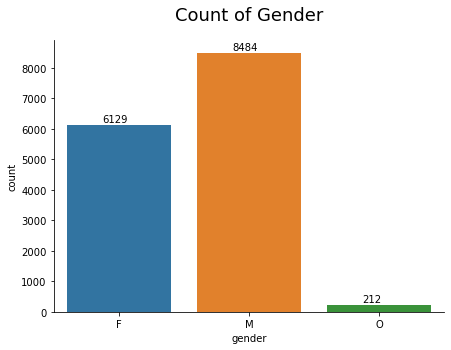

In [9]:
fig = plt.figure(figsize=[7,5])
ax = sns.countplot(x = profile['gender'])

for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.27, p.get_height()+100))
        
plt.title('Count of Gender', y=1.05,fontsize = 18)
sns.despine()

In [10]:
# Gender = O is dropped
profile = profile[profile['gender'].isin(['M','F'])]

#### Step 3: Create new feature *member duration*

This measures how long a someone has been a member (in days).

In [11]:
# Create the member_duration field
maxdate = profile['became_member_on'].max()
profile['member_duration'] = (maxdate - profile['became_member_on']).dt.days

#### Preliminary *profile* dataset

Following these pre-processing steps, there are 14,613 rows left in the *profile* dataset.

<b>New features:</b>

- *member_duration*: Days that customer has been a member.

In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14613 entries, 1 to 16999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14613 non-null  object        
 1   age               14613 non-null  int64         
 2   id                14613 non-null  object        
 3   became_member_on  14613 non-null  datetime64[ns]
 4   income            14613 non-null  float64       
 5   member_duration   14613 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 799.1+ KB


### 1.3 Transcript Dataset <a class="anchor" id="section1.3"></a>

There are 306,534 rows in the portfolio dataset. Each line represents unique customer and some demographic details as follows:

- *person*: Alphanumeric identifier, used to join to the profile (customer details) table 
- *event*: Offer received, offer seen, transaction, offer completed
- *value*: Input here depends on event as follows 
    - Offer received: offer id (to linked to portfolio (offer details) table)
    - Offer seen: empty
    - Transaction: transaction dollar amount
    - Offer completed: offer id (to linked to portfolio (offer details) table) and reward (same as in portfolio table)
- *time*: Time in hours since data collection has commenced.

In [13]:
transcript = pd.read_csv('data/transcript.csv')

# Drop redundant index column
transcript.drop('Unnamed: 0', axis = 1, inplace = True)

transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [14]:
# No nulls in this dataframe
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


#### Step 1: Split out the items in the *value* column to separate columns

Note that the below code was referenced from this [source](https://www.kaggle.com/moh3azzam/starbucks-capstone-notebook). This is the only point where another user's code has been reapplied.

In summary, it scans the value column to determine all the unique keys, creates columns for only the first two keys *offer id* and *amount* which contain useful new information and extracts the value associated with the key into the correct column.

In [15]:
import ast

def string_to_dict(val):
    return ast.literal_eval(val)

transcript['value'] = transcript['value'].apply(string_to_dict)

keys = []
def get_keys(val):
    if list(val.keys()) not in keys:
        keys.append(list(val.keys()))
        
transcript['value'].apply(get_keys)

keys = [item for elem in keys for item in elem]

print("The keys present in the value column are: "+str(keys))

def split_key(val):
    if list(val.keys())[0].startswith(key[:2]):
        return list(val.values())[0]
    else:
        return 0
    
try:      
    for key in keys[1:3]:
        transcript[key] = transcript['value'].apply(split_key)
except: pass

transcript.tail()

The keys present in the value column are: ['offer id', 'amount', 'offer_id', 'reward']


,person,event,value,time,amount,offer_id
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,1.59,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,9.53,0
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,3.61,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,3.53,0
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714,4.05,0


#### Step 2: Convert *time* from hour to days

In [16]:
transcript['days'] = transcript['time']/24

#### Step 3: Drop redundant columns

The columns 'value' and 'time' are no longer needed.

In [17]:
transcript = transcript.drop(['value','time'], axis = 1)
transcript.tail()

,person,event,amount,offer_id,days
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,1.59,0,29.75
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,9.53,0,29.75
306531,a00058cf10334a308c68e7631c529907,transaction,3.61,0,29.75
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,3.53,0,29.75
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,4.05,0,29.75


#### Preliminary *transcript* dataset

Following these pre-processing steps, there are still 306,534 rows in the *transcript* dataset.

<b>New features:</b>

- *amount*: Transaction amount
- *days*: Days since data collection has commenced.

In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306534 non-null  object 
 1   event     306534 non-null  object 
 2   amount    306534 non-null  float64
 3   offer_id  306534 non-null  object 
 4   days      306534 non-null  float64
dtypes: float64(2), object(3)
memory usage: 11.7+ MB


## 2. Create Combined DataFrame for Modelling<a class="anchor" id="section2"></a>

### 2.1 Group Related Transactions <a class="anchor" id="section2.1"></a>

Currently, each row in transcript dataset shows just one interaction the customer has with the Rewards App, but not the end-to-end journey from offer receipt to offer completed which is what we are really after.

An offer redemption success should only be considered if the offer passes through both offer seen and offer completed statuses. The rest should be considered failed.

<img src = "./images/customerjourneywstatus.png" width="700"/>

#### Step 1: Dummify event column, keep offers events and sort

- Filter out only offer related events and order by *person*, *offer id* and *days* such that earlier transactions for the same person & offer id come first
- Initialize an empty column *journey* to contain unique IDs for each string of related transactions

In [19]:
# Get dummies for all stages of transaction
transcript = pd.get_dummies(data=transcript, columns=['event'], prefix=None, drop_first=False)
transcript.rename(columns={'event_offer received':'offer received', 'event_offer viewed':'offer viewed',
                    'event_transaction':'transaction', 'event_offer completed':'offer completed' }, inplace = True)

# Keep only offers related columns, exclude transactions
keep = ['person', 'offer_id', 'days','offer received', 'offer viewed', 'offer completed']
offers_all = transcript[~transcript['offer_id'].isin([0])][keep]

# Order by person, time, amount and offer_id
sort = ['person', 'offer_id', 'days']
offers_all.sort_values(by=sort, inplace = True, )

# Insert a new columns 'journey' and reset index
offers_all['journey'] = 0
offers_all.reset_index(inplace=True, drop = True)

offers_all.head(10)

,person,offer_id,days,offer received,offer viewed,offer completed,journey
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.00,1,0,0,0
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.00,0,0,1,0
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.00,1,0,0,0
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,15.50,0,1,0,0
4,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.00,1,0,0,0
5,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,8.00,0,1,0,0
6,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.00,1,0,0,0
7,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.25,0,0,1,0
8,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,19.00,0,1,0,0
9,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.00,1,0,0,0


<b> Visually Inspect Related Transactions </b>

From the above, it can be seen that some of these transactions are related. E.g. for row 6, 7 and 8:
- (Line 6) On day 17, customer received the offer
- (Line 7) On day 17.25, customer completed the offer (redeemed)
- (Line 8) On day 19, customer saw the offer

As an aside, this means the offer was essentially wasted and should be counted as 'failed' as the customer did not see the offer yet redeemed it.

#### Step 2: Group related transactions via for-loop

- Step through each row and check the preceding row to see if transactions are related, if related then assign the same ID.

In [20]:
# Set first cell at journey 1
offers_all.loc[0,'journey'] = 1

for i in range (1, len(offers_all)):
    
    # person and offer id must match before this loop starts to be part of the same journey
    if (offers_all.loc[i,'person']==offers_all.loc[i-1,'person']) and (offers_all.loc[i,'offer_id']==offers_all.loc[i-1,'offer_id']):
        
        # If [1 0 0] before, then accept [0 1 0] or [0 0 1] as part of the same journey
        if offers_all.loc[i-1,'offer received'] == 1:
            if offers_all.loc[i,'offer viewed'] == 1 or offers_all.loc[i,'offer completed'] == 1:
                # Set current row i to the same journey number as the previous row
                offers_all.loc[i,'journey'] = offers_all.loc[i-1,'journey']
            else:
                # START NEW
                offers_all.loc[i,'journey'] = offers_all.loc[i-1,'journey'] + 1 
        
        # If [0 1 0] before, then accept [0 0 1] as part of the same journey
        elif offers_all.loc[i-1,'offer viewed'] == 1:
            if offers_all.loc[i,'offer completed'] == 1:
                # Set current row i to the same journey number as the previous row
                offers_all.loc[i,'journey'] = offers_all.loc[i-1,'journey']
            else:
                # START NEW
                offers_all.loc[i,'journey'] = offers_all.loc[i-1,'journey'] + 1 
        
        # If [0 0 1] before
        else:
            # START NEW
            offers_all.loc[i,'journey'] = offers_all.loc[i-1,'journey'] + 1 
    else:
        # START NEW
        offers_all.loc[i,'journey'] = offers_all.loc[i-1,'journey'] + 1 

offers_all.head()

,person,offer_id,days,offer received,offer viewed,offer completed,journey
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,1,0,0,1
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,0,1,1
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,1,0,0,2
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,15.5,0,1,0,2
4,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,1,0,0,3


In [21]:
# Aggregate the customer journeys by the column 'journey'
offers = offers_all.groupby(['person', 'offer_id', 'journey']).agg({'days':'max',
                                                                'offer received':'sum',
                                                                'offer viewed': 'sum',
                                                               'offer completed': 'sum'})
offers.reset_index(inplace = True)

#### Step 3: Second for-loop to address double redemption

Although rare, there are some cases where simply looking at the preceding row is not sufficient. This is because multiple offers can be sent in succession and redemptions happen after another of the same offer has been sent, breaking the flow. 

This is rare, happening in only about ~500 cases. However, there is a second for-loop here to correct for this by looking at the preceeding second-last row. 

In [22]:
for i in range (1, len(offers)):
    # if current row is 0-0-1,
    if (offers.loc[i,'offer received'] == 0
        and offers.loc[i,'offer viewed'] == 0
        and offers.loc[i,'offer completed'] == 1):
        
        # check if the SECOND LAST transaction is by the same person and with same offer id with no success
        if (offers.loc[i-2, 'person'] == offers.loc[i, 'person']
            and offers.loc[i-2, 'offer_id'] == offers.loc[i, 'offer_id']
            and offers.loc[i-2, 'offer completed'] == 0):
            
            # change the journey to the SECOND LAST journey
            offers.loc[i,'journey'] = offers.loc[i,'journey'] - 2
    
    # no action otherwise

In [23]:
# Manually correct the data for this person that did a triple redemption
offers.loc[16558, 'journey'] = offers.loc[16554, 'journey']

offers[offers['person'] == '3526938fb466470190a504a751ec07b0']

,person,offer_id,journey,days,offer received,offer viewed,offer completed
16553,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,16554,0.00,1,0,0
16554,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,16555,14.00,1,0,0
16555,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,16556,17.00,1,0,0
16556,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,16557,21.25,1,0,1
16557,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,16556,21.25,0,0,1
16558,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,16555,21.25,0,0,1
16559,3526938fb466470190a504a751ec07b0,ae264e3637204a6fb9bb56bc8210ddfd,16560,7.00,1,0,0
16560,3526938fb466470190a504a751ec07b0,f19421c1d4aa40978ebb69ca19b0e20d,16561,27.25,1,1,1


In [24]:
# Repeat groupby and check
offers = offers.groupby(['person', 'offer_id', 'journey']).agg({'days':'max',
                                                                'offer received':'sum',
                                                                'offer viewed': 'sum',
                                                               'offer completed': 'sum'})

offers.reset_index(inplace = True)
offers.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
journey,80483.0,40480.282457,23361.711172,1.0,20253.50,40486.0,60718.50,80945.00
days,80483.0,15.573543,8.258551,0.0,8.25,17.0,22.25,29.75
offer received,80483.0,0.947741,0.222551,0.0,1.00,1.0,1.00,1.00
offer viewed,80483.0,0.717232,0.450347,0.0,0.00,1.0,1.00,1.00
offer completed,80483.0,0.417219,0.493103,0.0,0.00,0.0,1.00,1.00


In [25]:
# Visually inspect data from one person
offers[offers['person'] == '3526938fb466470190a504a751ec07b0']

,person,offer_id,journey,days,offer received,offer viewed,offer completed
16446,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,16554,0.00,1,0,0
16447,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,16555,21.25,1,0,1
16448,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,16556,21.25,1,0,1
16449,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,16557,21.25,1,0,1
16450,3526938fb466470190a504a751ec07b0,ae264e3637204a6fb9bb56bc8210ddfd,16560,7.00,1,0,0
16451,3526938fb466470190a504a751ec07b0,f19421c1d4aa40978ebb69ca19b0e20d,16561,27.25,1,1,1


#### Final Offers Dataframe

After grouping, there are 80,945 unique customer journeys. 

<b>All features:</b>

- *person*: Alphanumeric identifier, used to join to the profile (customers) table
- *offer_id*: Alphanumeric identifier, used to join to the portfolio (offers) table
- *journey*: Unique identifier of each set of transactions from offer receipt to completion / failure 
- *days*: Days since data collection has commenced.
- *offer received*: 0 if not False, 1 if True
- *offer viewed*: 0 if not False, 1 if True
- *offer completed*: 0 if not False, 1 if True

In [26]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80483 entries, 0 to 80482
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   person           80483 non-null  object 
 1   offer_id         80483 non-null  object 
 2   journey          80483 non-null  int64  
 3   days             80483 non-null  float64
 4   offer received   80483 non-null  uint8  
 5   offer viewed     80483 non-null  uint8  
 6   offer completed  80483 non-null  uint8  
dtypes: float64(1), int64(1), object(2), uint8(3)
memory usage: 2.7+ MB


### 2.2 Merge DataFrames <a class="anchor" id="section2.2"></a>

#### Step 1: Create the transactions DataFrame

This simple transactions DataFrame will be used to merge transactions data with the offers DataFrame.

In [27]:
transactions = transcript[transcript['transaction']==1][['person','days','amount']].reset_index(drop = True)
transactions.head()

,person,days,amount
0,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
2,54890f68699049c2a04d415abc25e717,0.0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


#### Step 2: Join all relevant tables

- Join 1: Offers to Profile (inner join), yielding <b>df_class</b>
- Join 2: <b>df_class</b> to Portfolio (inner join), yielding <b>df_class</b>
- Join 3: <b>df_class</b> to Transactions (left join), yielding <b>df_class</b>

In [28]:
# Inner join of offers and person
df_class = offers.merge(profile, left_on = 'person', right_on = 'id')
df_class.drop(['id','became_member_on'], inplace = True, axis = 1)

# Inner join of offers and portfolio
df_class = df_class.merge(portfolio, left_on = 'offer_id', right_on = 'id', how = 'inner')
df_class.drop('id', inplace = True, axis = 1)

# Left join of offers and transactions, use composite primary key of person & time to join to transactions
# This will only pick up the transaction value whre offer success is 1 because offer success = same as of the spend
# You may verify this in the transcript data directly
df_class = df_class.merge(transactions, left_on = ['person','days'], right_on = ['person','days'], how = 'left')
df_class['amount'] = df_class['amount'].fillna(0)

# Force amount = 0 where offer success = 0, as customers may have spent that day by chance unrelated to the offer
df_class['amount'] = np.where(df_class['offer completed'] == 1,df_class['amount'], 0)

df_class.head()

,person,offer_id,journey,days,offer received,offer viewed,offer completed,gender,age,income,...,reward,difficulty,duration,offer_type,channel_web,channel_mobile,channel_social,channel_email,promo_name,amount
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,24.00,1,0,1,M,33,72000.0,...,2,10,7,discount,1,1,0,1,disc-1,10.27
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,30,17.00,1,0,0,F,19,65000.0,...,2,10,7,discount,1,1,0,1,disc-1,0.00
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,31,24.00,1,0,0,F,19,65000.0,...,2,10,7,discount,1,1,0,1,disc-1,0.00
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,43,17.00,1,0,0,M,56,47000.0,...,2,10,7,discount,1,1,0,1,disc-1,0.00
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,65,22.25,1,0,1,F,58,119000.0,...,2,10,7,discount,1,1,0,1,disc-1,21.35


#### Step 3: Add descriptors for each type of customer journey 



We now tag each series of events in a customer journey with a descriptive tag as per the "Scenario Description" column.

<img src = "./images/customerjourneywstatus.png" width="700"/>

In [29]:
# Binning the income range and age groups
df_class['catcoding'] = df_class[['offer received', 
                                  'offer viewed', 'offer completed']].astype(str).agg('-'.join, axis=1)

categories = {'1-1-1': 'success', '1-1-0':'failed, seen', '1-0-0':'failed, not seen',
             '1-0-1': 'failed, completed', '0-1-0':'error1', '0-0-1': 'error2'}
df_class['scenario_description'] = df_class['catcoding'].map(categories)

df_class = df_class[df_class['scenario_description'] != 'error1']

print('The number of rows left are: ' + str(len(df_class)))

The number of rows left are: 65600


In [30]:
df_class.head()

,person,offer_id,journey,days,offer received,offer viewed,offer completed,gender,age,income,...,duration,offer_type,channel_web,channel_mobile,channel_social,channel_email,promo_name,amount,catcoding,scenario_description
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,24.00,1,0,1,M,33,72000.0,...,7,discount,1,1,0,1,disc-1,10.27,1-0-1,"failed, completed"
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,30,17.00,1,0,0,F,19,65000.0,...,7,discount,1,1,0,1,disc-1,0.00,1-0-0,"failed, not seen"
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,31,24.00,1,0,0,F,19,65000.0,...,7,discount,1,1,0,1,disc-1,0.00,1-0-0,"failed, not seen"
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,43,17.00,1,0,0,M,56,47000.0,...,7,discount,1,1,0,1,disc-1,0.00,1-0-0,"failed, not seen"
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,65,22.25,1,0,1,F,58,119000.0,...,7,discount,1,1,0,1,disc-1,21.35,1-0-1,"failed, completed"


### 2.3 Check For & Remove Outliers <a class="anchor" id="section2.3"></a>

From the preliminary summary of <b>df</b>, we observe that there are odd values for:
- *age*: Max value is at 101 years old
- *amount*: Max value is at 1015.73 dollars

In [31]:
df_class.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
journey,65600.0,40497.940960,23355.379509,1.0,20328.75,40532.0,60697.25,80945.00
days,65600.0,15.538255,8.268852,0.0,8.25,17.0,22.25,29.75
offer received,65600.0,0.999771,0.015120,0.0,1.00,1.0,1.00,1.00
offer viewed,65600.0,0.686128,0.464069,0.0,0.00,1.0,1.00,1.00
offer completed,65600.0,0.486936,0.499833,0.0,0.00,0.0,1.00,1.00
age,65600.0,54.363354,17.412203,18.0,42.00,55.0,66.00,101.00
income,65600.0,65400.015244,21654.661078,30000.0,49000.00,64000.0,80000.00,120000.00
member_duration,65600.0,522.646723,419.808510,0.0,208.00,358.0,798.00,1823.00
reward,65600.0,4.200442,3.398769,0.0,2.00,5.0,5.00,10.00
difficulty,65600.0,7.716387,5.545432,0.0,5.00,10.0,10.00,20.00


In [32]:
# Create helper functions to check outliers
def outlier_check(var, df_name):
    sns.displot(data = df_name, x = var)
    print('Variable: ', var) 
    print('Minimum value: ', df_name[var].min())
    print('10th percentile: ', df_name[var].quantile(0.1))
    print('90th percentile: ', df_name[var].quantile(0.90))
    print('95th percentile: ', df_name[var].quantile(0.95))
    print('97th percentile: ', df_name[var].quantile(0.97))
    print('Maximum value: ', df_name[var].max())

<b>Age:</b> Values above 85 years old to be dropped. While distribution is fairly normal, it seems inprobable that such elderly individuals would still be frequently consuming Starbucks.

Summary Statistics before outlier removal:
Variable:  age
Minimum value:  18
10th percentile:  29.0
90th percentile:  77.0
95th percentile:  83.0
97th percentile:  87.0
Maximum value:  101


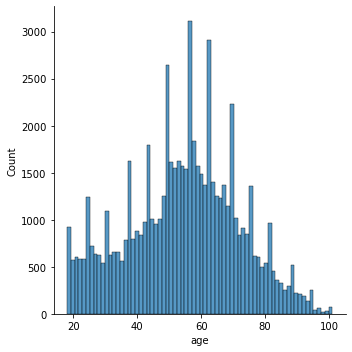

In [33]:
print('Summary Statistics before outlier removal:')
outlier_check('age', df_class)

Summary Statistics after outlier removal:
Variable:  age
Minimum value:  18
10th percentile:  28.0
90th percentile:  73.0
95th percentile:  77.0
97th percentile:  80.0
Maximum value:  83


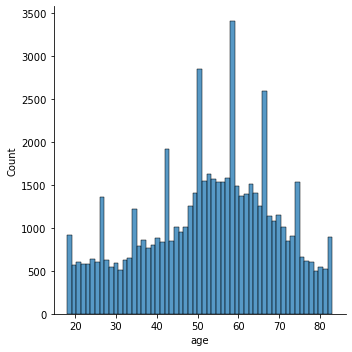

In [34]:
# Drop values above 85 years old
df_class=df_class[df_class['age']<=83]

print('Summary Statistics after outlier removal:')
outlier_check('age', df_class)

<b>Amount:</b> Values above \\$50 are dropped. This is above the 97th percentile (\\$32) and includes values from USD\\$50 to USD\\$1031. Amounts above \\$50 are likely for larger events e.g., corporate purchases which are not the focus of individually targeted promotions.

Summary Statistics before outlier removal:
Variable:  amount
Minimum value:  0.0
10th percentile:  0.0
90th percentile:  25.04
95th percentile:  29.72
97th percentile:  32.94
Maximum value:  1015.73


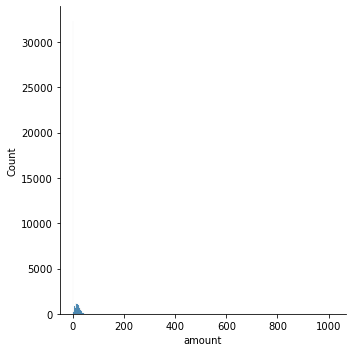

In [35]:
print('Summary Statistics before outlier removal:')
outlier_check('amount', df_class)

Summary Statistics after outlier removal:
Variable:  amount
Minimum value:  0.0
10th percentile:  0.0
90th percentile:  24.685000000000002
95th percentile:  29.09
97th percentile:  31.85
Maximum value:  49.92


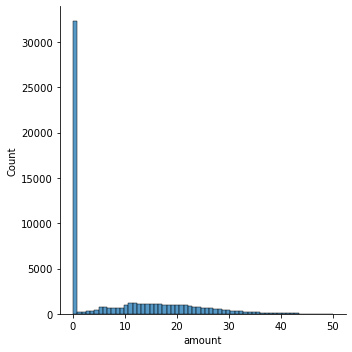

In [36]:
# Drop values above $50
df_class=df_class[df_class['amount']<=50]

print('Summary Statistics after outlier removal:')
outlier_check('amount', df_class)

In [37]:
df_class.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
journey,62306.0,40448.488829,23358.829145,1.0,20251.25,40499.5,60637.75,80945.00
days,62306.0,15.521390,8.267199,0.0,8.25,17.0,22.25,29.75
offer received,62306.0,0.999759,0.015514,0.0,1.00,1.0,1.00,1.00
offer viewed,62306.0,0.687061,0.463694,0.0,0.00,1.0,1.00,1.00
offer completed,62306.0,0.482008,0.499680,0.0,0.00,0.0,1.00,1.00
age,62306.0,52.733075,16.030530,18.0,42.00,54.0,65.00,83.00
income,62306.0,65171.636761,21588.344097,30000.0,49000.00,63000.0,79000.00,120000.00
member_duration,62306.0,522.277116,421.644344,0.0,207.00,356.0,798.00,1823.00
reward,62306.0,4.197333,3.398099,0.0,2.00,5.0,5.00,10.00
difficulty,62306.0,7.708969,5.548022,0.0,5.00,8.5,10.00,20.00


### 2.4 Final Cleanup & Summary<a class="anchor" id="section2.4"></a>

In [38]:
# Drop channel_email as it is 1 for all and does not tell us anything incremental
df_class = df_class.drop(['channel_email'], axis=1)

# Drop informational offers as expected value is 0 (prior knowledge)
df_class= df_class[(df_class.offer_type != 'informational')]

In [39]:
print('Unique individuals:', len(df_class['person'].unique()))
print('Unique promotions:', len(df_class['offer_id'].unique()))
df_class.info()

Unique individuals: 13894
Unique promotions: 8
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49824 entries, 0 to 69676
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   person                49824 non-null  object  
 1   offer_id              49824 non-null  object  
 2   journey               49824 non-null  int64   
 3   days                  49824 non-null  float64 
 4   offer received        49824 non-null  uint8   
 5   offer viewed          49824 non-null  uint8   
 6   offer completed       49824 non-null  uint8   
 7   gender                49824 non-null  object  
 8   age                   49824 non-null  int64   
 9   income                49824 non-null  float64 
 10  member_duration       49824 non-null  int64   
 11  reward                49824 non-null  int64   
 12  difficulty            49824 non-null  int64   
 13  duration              49824 non-null  int64   
 14  offer_t

In [40]:
df_class.to_csv('data/preprocessed_data.csv', index = False)